In [338]:
import serial
import numpy as np
import matplotlib.pyplot as plt
import math

def GetLine():
    Line = []
    ser.write("1")
    i = 0
    while (i<2):        
        Line.append(ser.readline().strip())
        i=i+1 
    return Line

In [354]:
try:
    ser = serial.Serial('/dev/ttyACM0', 9600)
except serial.SerialException:
    ser = serial.Serial('/dev/ttyACM1', 9600)
print(ser.name) 

/dev/ttyACM0


8192


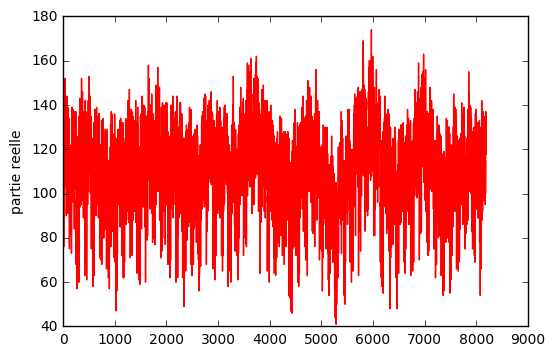

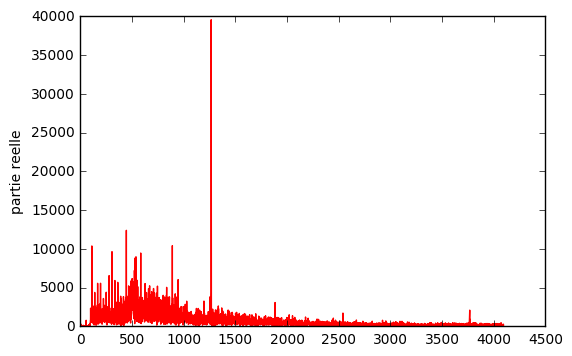

In [356]:
rawData = GetLine()
signal = np.asarray(rawData[0].split(" ")[-1].split(";EOF")[0].split(";"),dtype=int)
rawFFT = np.asarray(rawData[1].split(" ")[-1].split(";EOF")[0].split(";"),dtype=int)
 
print len(signal)
signal[-1]= signal[-6]
for i in range(5):
    signal[-i]= signal[-6]
#data = np.asarray(rawData[1].split(" ")[-1].split(";EOF")[0].split(";"))
#dataTime = int(rawData[1].split(" ")[2]) - int(rawData[1].split(" ")[1])
FFT = np.fft.fft(signal)




for i in range(5):
    FFT[i] = 0
    FFT[-i] = 0 


for i in range(100):
    FFT[i] = FFT[i]/(100-i)
    FFT[-i] = FFT[-i]/(100-i)
    
plt.plot(signal,"r")
plt.ylabel("partie reelle")
plt.show()

#plt.plot(range(128),np.abs(FFT[0:128]))
plt.plot(np.abs(FFT[0:len(FFT)/2]),"r")
plt.ylabel("partie reelle")

plt.show()


In [363]:
PeakAt8kHz = np.argmax(np.abs(FFT[0:len(FFT)/2]))
SamplingFreq = 2*8000*(4096.0/PeakAt8kHz)
print(SamplingFreq)
N = len(FFT)
Npt = len(signal)
Freqs = [SamplingFreq * x /N for x in range(N/2)]
t = [ 1.0*x/SamplingFreq for x in range(Npt)]

51766.192733


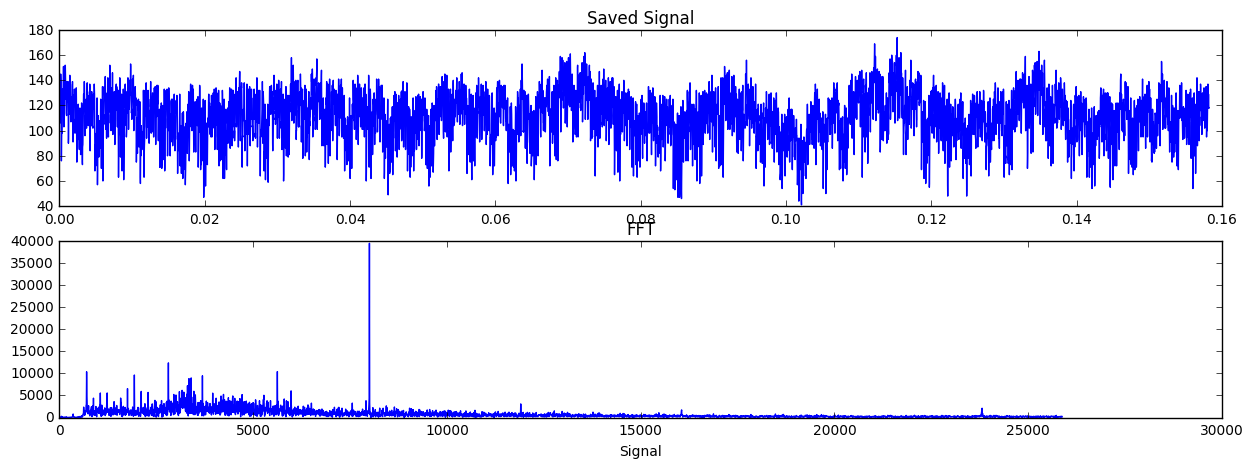

In [366]:
f, (ax1, ax2) = plt.subplots(2, 1,figsize=(15,5))
ax1.plot(t,signal)
ax1.set_title('Saved Signal')
plt.xlabel("Time (us)")
ax2.plot(Freqs, np.abs(FFT[0:len(FFT)/2]))
ax2.set_title('FFT')
plt.xlabel("Signal")
plt.show()

In [361]:
np.savez("8kHzData.npz", FFT=FFT, signal=signal)

# Arduino code 

Arduino code

<code>
/*
  Blink

*/

// DISPLAY

#include <Adafruit_GFX.h>
#include <Adafruit_SSD1306.h>
#include <adafruit_feather.h>
#include <avr/pgmspace.h>
// Managing arrays


#include "arduinoFFT.h"
 #include <WProgram.h>
arduinoFFT FFT = arduinoFFT(); /* Create FFT object */

const uint16_t FFT_N = 256; // set to 256 point fft 



// OLED
#define OLED_RESET 4
Adafruit_SSD1306 display(OLED_RESET);


unsigned long time1 = 0;
unsigned long time2 = 0;

#define DECIMATION 1
#define BUFFERSIZE 2048

#define   VaLEn 4*BUFFERSIZE
byte val[VaLEn];

uint8_t  calib[32];

int j = 0;
int k = 0;
int i = 0;

int led3 = PA15;
int sensorPin1 = PA1;

// the setup function runs once when you press reset or power the board
void setup() {

  pinMode(sensorPin1, INPUT_ANALOG);


  // initialize digital pin 13 as an output.
  pinMode(13, OUTPUT);
  digitalWrite(13, HIGH);





  // Display
  display.begin(SSD1306_SWITCHCAPVCC, 0x3C);  // initialize with the I2C addr 0x3D (for the 128x64)
  display.clearDisplay();
  display.setTextSize(1);
  display.setTextColor(WHITE);
  display.setCursor(0, 0);
  display.println(F("== Test starting == "));
  display.print(F("Free SRAM: ->  "));
  display.println(freeRam ());
  display.display();



  digitalWrite(13, LOW);
  delay(500);
}

// the loop function runs over and over again forever
void loop() {

  while (Serial.available()) {
    int lu = Serial.read() - 48;
    display.println(lu);
    display.display();
    if (lu == 1) {
      display.println("Lu == 1");
      display.display();


      transmit();


    }
    lu = 0;
  }






}


void transmit()
{
  int l = 0;
  i = 0;
  time1 = micros();

  while (i < VaLEn) {
    val[i] = 0;
    i++;
  }

  int tmpValue = 0;

  noInterrupts();
  while (i < 256) {
    // ADC : page 212 to 254 in the reference manual
    /*
        //start conversion
        ADC1->regs->CR2 |= ADC_CR2_SWSTART; //SWSTART: Start conversion of regular channels
        ADC2->regs->CR2 |= ADC_CR2_SWSTART;
        // Wait the end of the conversion ( 1: Conversion complete (EOCS=0), or sequence of conversions complete (EOCS=1) )
        while (!(ADC1->regs->SR & ADC_SR_EOC & ADC2->regs->SR )) ;
        //get the values converted from the two ADCs.
        // they are sharing the same channel, in interleaved mode
    */


    tmpValue = analogRead(PA1);
    tmpValue += analogRead(PA1);
    tmpValue += analogRead(PA1);
    tmpValue += analogRead(PA1);

    tmpValue += analogRead(PA1);
    tmpValue += analogRead(PA1);
    tmpValue += analogRead(PA1);
    tmpValue += analogRead(PA1);

    calib[i] =  tmpValue;
    i++;
  }

  int CalibMin = 0;
  int CalibMax = 0;
  int CalibAve = 0;

  while (i < 256) {
    if (calib[i] < CalibMin) {
      CalibMin = calib[i];
    };
    if (calib[i] > CalibMax) {
      CalibMax = calib[i];
    };
    CalibAve += calib[i];
    i++;
  }
  CalibAve = CalibAve  / 256;



  int spread = (CalibMin - CalibAve + CalibMax - CalibAve) / 2;

  interrupts();


  digitalWrite(13, HIGH);
  // turn the LED on (HIGH is the voltage level)
  delay(100);              // wait for a second



  //  ADC_TIME_52; // Normal Aduino Setting (52us)
  i = 0;

  time1 = micros();
  noInterrupts();
  while (i < VaLEn) {
    // ADC : page 212 to 254 in the reference manual
    /*
        //start conversion
        ADC1->regs->CR2 |= ADC_CR2_SWSTART; //SWSTART: Start conversion of regular channels
        ADC2->regs->CR2 |= ADC_CR2_SWSTART;
        // Wait the end of the conversion ( 1: Conversion complete (EOCS=0), or sequence of conversions complete (EOCS=1) )
        while (!(ADC1->regs->SR & ADC_SR_EOC & ADC2->regs->SR )) ;
        //get the values converted from the two ADCs.
        // they are sharing the same channel, in interleaved mode
    */


    tmpValue = analogRead(PA1);
    tmpValue += analogRead(PA1);
    tmpValue += analogRead(PA1);
    tmpValue += analogRead(PA1);

    tmpValue += analogRead(PA1);
    tmpValue += analogRead(PA1);
    tmpValue += analogRead(PA1);
    tmpValue += analogRead(PA1);

    tmpValue += analogRead(PA1);
    tmpValue += analogRead(PA1);
    tmpValue += analogRead(PA1);
    tmpValue += analogRead(PA1);

    tmpValue += analogRead(PA1);
    tmpValue += analogRead(PA1);
    tmpValue += analogRead(PA1);
    tmpValue += analogRead(PA1);

    //tmpValue += analogRead(PA1);
    //tmpValue += analogRead(PA1);
    //tmpValue += analogRead(PA1);
    //tmpValue += analogRead(PA1);

    val[i] =  tmpValue / 4;
    i++;
  }

  interrupts();
  time2 = micros();


  int GoodSignal = 0;
  l = 0;
  while (l < (VaLEn / DECIMATION)) {
    GoodSignal = 0;
    for (i = 0; i < DECIMATION; i++) {
      GoodSignal += float ((val[DECIMATION * l + i] / (DECIMATION)) - CalibAve);
    }
    GoodSignal = 127 + float((GoodSignal) ) - 100 ;

    Serial.print(GoodSignal);
    Serial.print(";");
    l++;

  }
  Serial.println("EOF");





  display.clearDisplay();
  display.setCursor(0, 0);
  display.println(freeRam ());
  display.display();

  digitalWrite(13, LOW);    // turn the LED off by making the voltage LOW


/*
  i = 0;
  while (i < FFT_N) {
    vReal[i] = 0;
    i++;
  }

  int NbDecFFT = (VaLEn / FFT_N);
  i = 0;
  while (i < FFT_N) {
    j = 0;
    while (j < NbDecFFT) {
      vReal[i] += double(val[ i * NbDecFFT + j]);
      j++;
    }
     vReal[i] = double( vReal[i]);
    i++;
  }
*/
/*
  display.println("Doing the windowing");
  display.display();

  FFT.Windowing(vReal, FFT_N, FFT_WIN_TYP_HAMMING, FFT_FORWARD);
  
  display.println("Doing compute");
  display.display();
   
  FFT.Compute(vReal, vImag, FFT_N, FFT_FORWARD); /* Compute FFT */
 
    

//  FFT.ComplexToMagnitude(vReal, vImag, FFT_N); /* Compute magnitudes */


  //fft_window();
  //fft_reorder(); // reorder the data before doing the fft
  //fft_run(); // process the data in the fft


  l = 0;
  int high = 0;
  while (l < FFT_N) {
    //high = ((unsigned int)sq(fft_input[l << 1]) + (unsigned int)sq(fft_input[(l << 1) + 1])) >> 1; //the bin value really = sqrt(sq(re) + sq(im)) but this is faster and is still easy to read
//    high = vReal[l];
    Serial.print(high);
    Serial.print(";");
    l++;
  }
  Serial.println("EOF");





}


int freeRam ()
{
  extern int __heap_start, *__brkval;
  int v;
  return (int) &v - (__brkval == 0 ? (int) &__heap_start : (int) __brkval);
}

</code>